In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [4]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('mgpASNase_Metformin_Asp-level.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename'].values]

        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [5]:
# metab_names_mes

In [6]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
# Fix long treatment name:
df['Treatment'] = [v.replace('+', '+\n') for v in df['Treatment'].values]
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values

In [7]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['DHAP-G3P'] = (df['DHAP neg'] / df['Glycerol 3-phosphate neg']).replace(np.inf, np.nan)
df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)

In [8]:
df_mean = df.groupby(['Exp_time', 'Cell_line', 'Treatment']).mean().reset_index()
df_stdev = df.groupby(['Exp_time', 'Cell_line', 'Treatment']).std().reset_index()

In [9]:
df

,Sample ID,ISTD Amt,Sample_name,Exp_time,Cell_line,Drug,Dose,Treatment,dilution,3-Phosphoglycerate neg,...,SAICAR pos,Serine neg,Succinate neg,UMP neg,Uridine neg,Xanthine neg,NAD-NADH,IMP-AMP,DHAP-G3P,Pyr-Lac
0,0.0,0,LS01,Short,WT,Vehicle,0,Vehicle,0.0225,4.288462e+07,...,8.977378e+07,33.165619,7.230253e+08,0.109106,7.796267e+06,7.210964e+07,29.239564,0.008069,3.424771e+09,0.016435
1,0.0,0,LS02,Short,WT,Vehicle,0,Vehicle,0.0225,4.899893e+07,...,1.939152e+08,38.815955,6.917216e+08,0.122106,1.569756e+07,3.966978e+07,45.597895,0.006428,3.750397e+09,0.017314
2,0.0,0,LS03,Short,mgpASNase1,Vehicle,0,Vehicle,0.0225,5.032218e+07,...,2.280597e+08,43.568409,1.669733e+09,0.080451,4.842249e+07,2.133396e+09,144.816597,0.021274,1.440612e+09,0.072474
3,0.0,0,LS04,Short,mgpASNase1,Vehicle,0,Vehicle,0.0225,4.643204e+07,...,1.680476e+08,39.285960,7.207280e+08,0.119151,7.148311e+06,2.545813e+07,54.754825,0.008777,1.218753e+09,0.006203
4,0.0,0,LS05,Short,WT,Metformin,300,300 μM Metformin,0.0225,3.760147e+07,...,9.258698e+07,37.334227,4.815736e+08,0.085085,1.811280e+07,7.881213e+07,29.196923,0.007350,3.802893e+09,0.004940
5,0.0,0,LS06,Short,WT,Metformin,300,300 μM Metformin,0.0225,5.195662e+07,...,1.633114e+08,39.907929,6.318842e+08,0.134864,1.088413e+07,7.926013e+07,51.037932,0.005990,4.022126e+09,0.004718
6,0.0,0,LS07,Short,mgpASNase1,Metformin,300,300 μM Metformin,0.0225,3.441929e+07,...,1.591668e+08,43.928999,4.322348e+08,0.092415,1.592307e+07,8.579124e+07,34.061311,0.054441,7.839211e+08,0.003359
7,0.0,0,LS08,Short,mgpASNase1,Metformin,300,300 μM Metformin,0.0225,5.378356e+07,...,1.509529e+08,48.344613,5.703935e+08,0.091973,9.695911e+06,4.143747e+07,32.523425,0.052743,8.112538e+08,0.003917
8,0.0,0,LS09,Short,WT,Metformin,500,500 μM Metformin,0.0225,4.812538e+07,...,1.669829e+08,43.787165,4.540759e+08,0.103680,1.037129e+07,6.665876e+07,39.826961,0.012208,3.024508e+09,0.006456
9,0.0,0,LS10,Short,WT,Metformin,500,500 μM Metformin,0.0225,4.337702e+07,...,1.442158e+08,41.429023,5.556888e+08,0.093139,6.242000e+06,1.231278e+08,41.622395,0.006544,3.119191e+09,0.005024


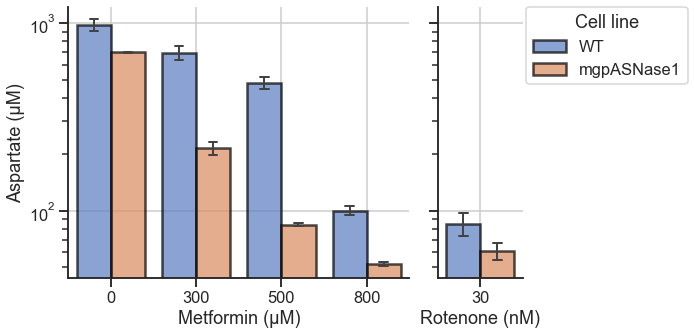

In [10]:
### Aspartate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Aspartate conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Aspartate (μM)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Aspartate conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Aspartate.pdf', bbox_inches='tight')

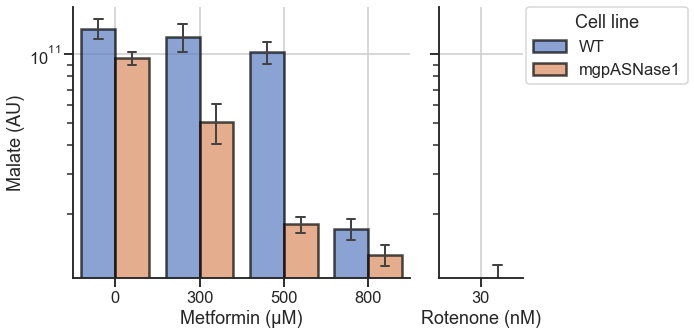

In [11]:
### Malate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Malate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Malate (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Malate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Malate.pdf', bbox_inches='tight')

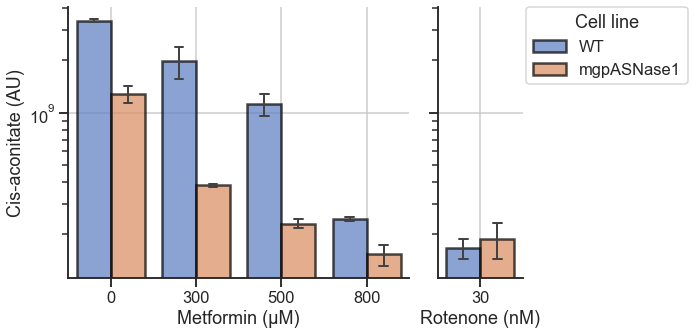

In [10]:
### Cis-aconitate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Cis-aconitate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Cis-aconitate (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Cis-aconitate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Cis-aconitate.pdf', bbox_inches='tight')

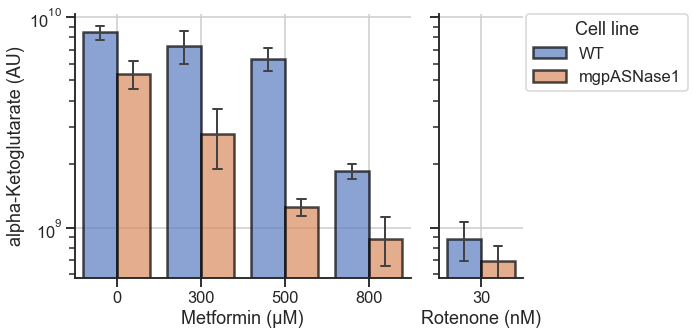

In [12]:
### aKG as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='alpha-Ketoglutarate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('alpha-Ketoglutarate (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='alpha-Ketoglutarate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-alpha-Ketoglutarate.pdf', bbox_inches='tight')

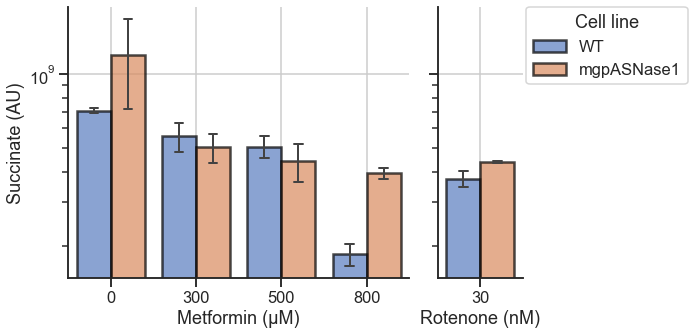

In [10]:
### Succinate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Succinate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Succinate (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Succinate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Succinate.pdf', bbox_inches='tight')

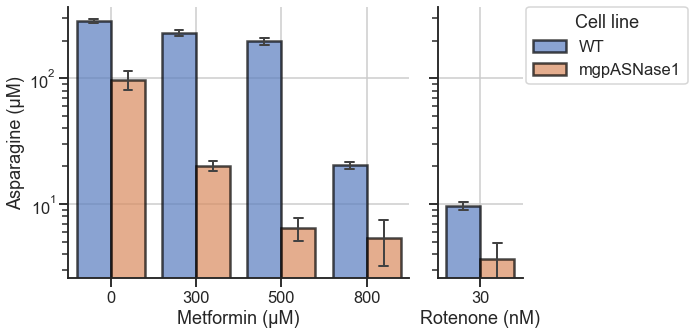

In [11]:
### Aspargine as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Asparagine conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Asparagine (μM)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Asparagine conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Asparagine.pdf', bbox_inches='tight')

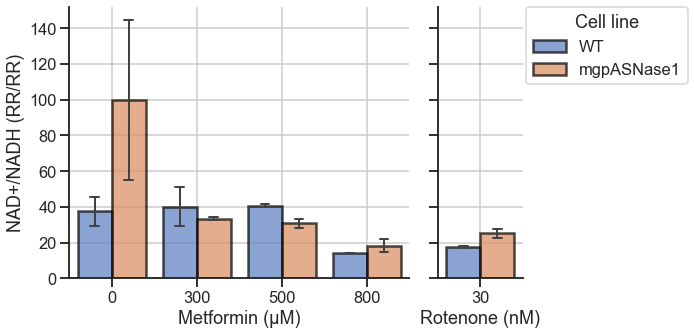

In [12]:
### NAD/NADH as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='NAD-NADH', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('NAD+/NADH (RR/RR)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='NAD-NADH', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-NAD-NADH.pdf', bbox_inches='tight')

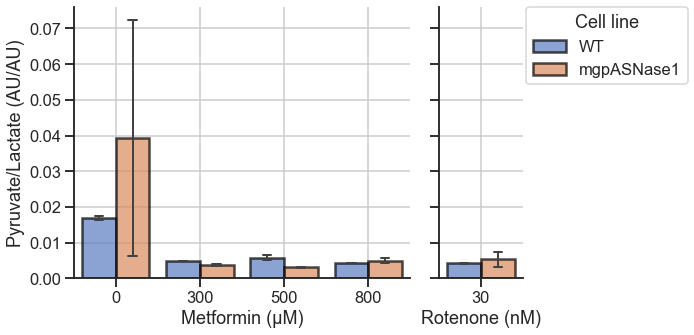

In [13]:
### Pyr/Lac as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Pyr-Lac', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Pyruvate/Lactate (AU/AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Pyr-Lac', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Pyr-Lac.pdf', bbox_inches='tight')

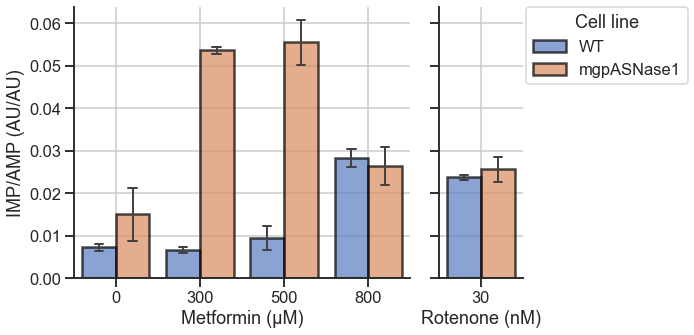

In [14]:
### IMP/AMP as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='IMP-AMP', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('IMP/AMP (AU/AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='IMP-AMP', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-IMP-AMP.pdf', bbox_inches='tight')

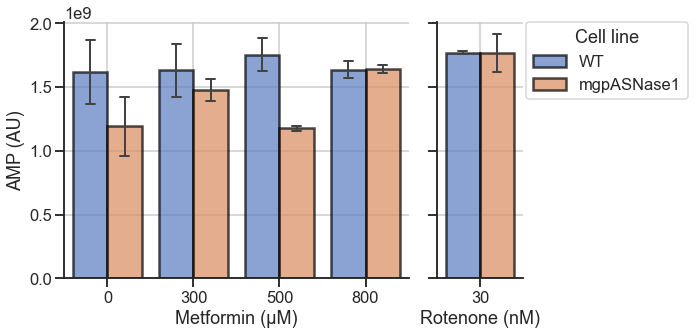

In [15]:
### AMP as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='AMP pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('AMP (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='AMP pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-AMP.pdf', bbox_inches='tight')

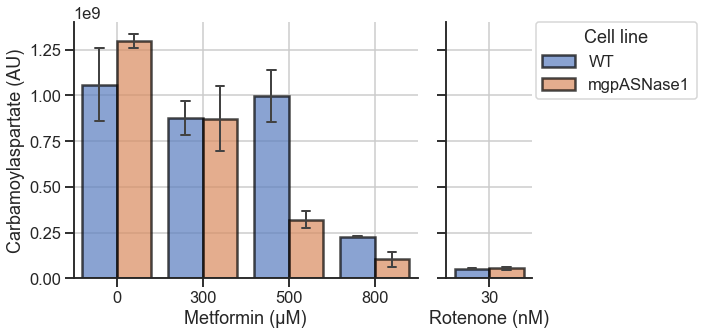

In [16]:
### Carbamoylaspartate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Carbamoylaspartate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Carbamoylaspartate (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Carbamoylaspartate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Carbamoylaspartate.pdf', bbox_inches='tight')

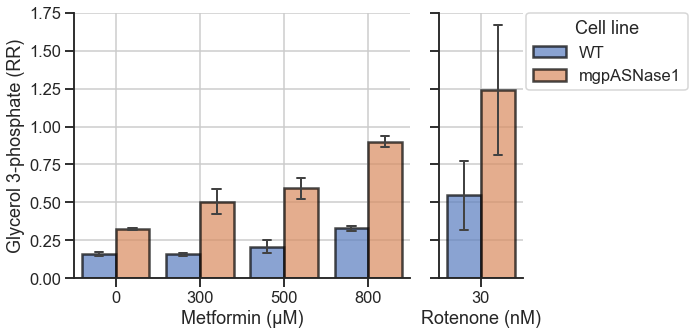

In [17]:
### Glycerol 3-phosphate as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Glycerol 3-phosphate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Glycerol 3-phosphate (RR)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Glycerol 3-phosphate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Glycerol-3-phosphate.pdf', bbox_inches='tight')

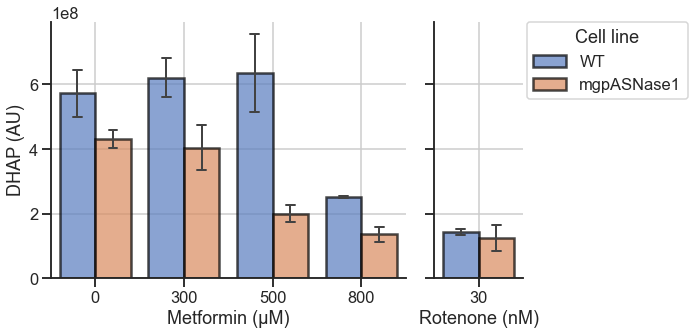

In [18]:
### DHAP as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='DHAP neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('DHAP (AU)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='DHAP neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-DHAP.pdf', bbox_inches='tight')

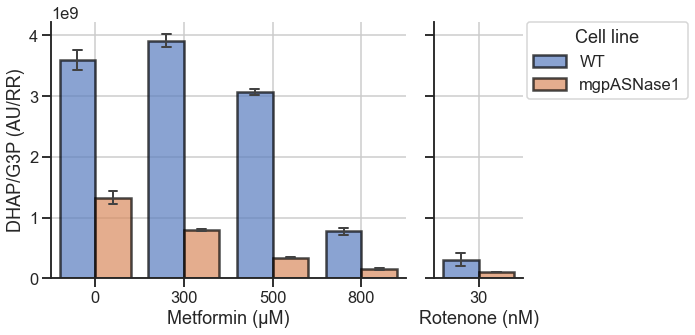

In [19]:
### DHAP/G3P as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='DHAP-G3P', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('DHAP/G3P (AU/RR)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='DHAP-G3P', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-DHAP-G3P.pdf', bbox_inches='tight')

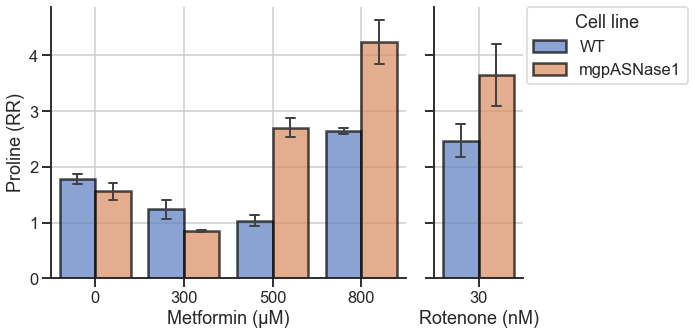

In [20]:
### Proline as a function of ETC inhibitor ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})

mask = (df['Exp_time'] == 'Short') & ((df['Drug'] == 'Metformin') | (df['Drug'] == 'Vehicle'))
g1 = sns.barplot(ax=ax1, data=df[mask], x='Dose', y='Proline pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Proline (RR)')
g1.grid(True)
g1.legend_.remove()


mask = (df['Exp_time'] == 'Short') & (df['Drug'] == 'Rotenone')
g2 = sns.barplot(ax=ax2, data=df[mask], x='Dose', y='Proline pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g2.set(yscale="log")

g2.set_xlabel('Rotenone (nM)')
g2.set_ylabel('')
g2.grid(True)

old_legend = g2.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g2.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left");


sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Met-Rot-Proline.pdf', bbox_inches='tight')

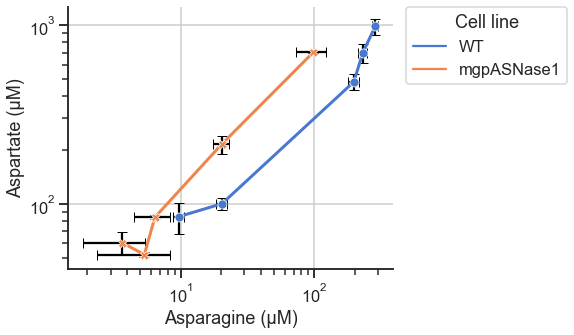

In [21]:
### Aspartate as a function of Asparagine ###

fig, ax1 = plt.subplots(1, 1, figsize=(8.4, 5))

mask = (df_mean['Exp_time'] == 'Short')
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Asparagine conc', y='Aspartate conc', hue='Cell_line',
             style='Cell_line', markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean[mask]['Aspartate conc'].values, x=df_mean[mask]['Asparagine conc'].values, yerr=df_stdev[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Asparagine conc'].values, fmt='none', color='black', capsize=5, zorder=1)
g1.set(yscale="log", xscale="log")

g1.set_xlabel('Asparagine (μM)')
g1.set_ylabel('Aspartate (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
#title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/short_Asn-Asp.pdf', bbox_inches='tight')

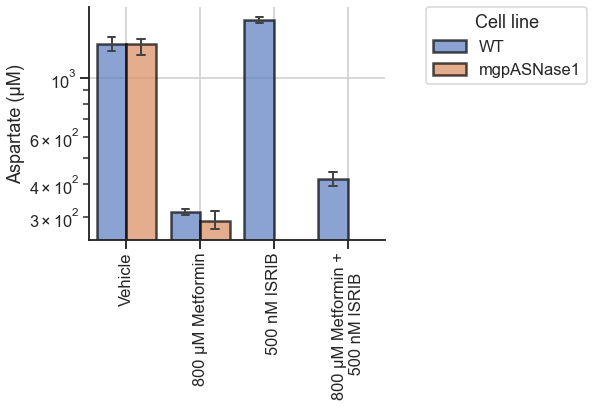

In [22]:
### Aspartate as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Aspartate conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Aspartate (μM)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Aspartate.pdf', bbox_inches='tight')

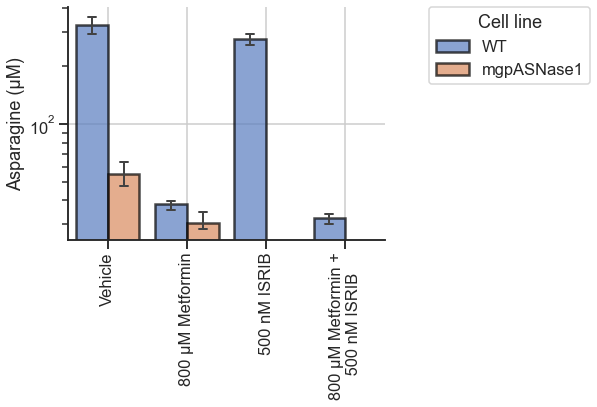

In [23]:
### Asparagine as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Asparagine conc', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Asparagine (μM)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Asparagine.pdf', bbox_inches='tight')

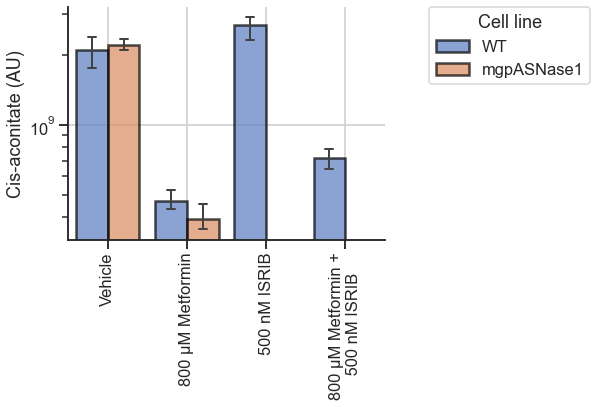

In [11]:
### Cis-aconitate as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Cis-aconitate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Cis-aconitate (AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Cis-aconitate.pdf', bbox_inches='tight')

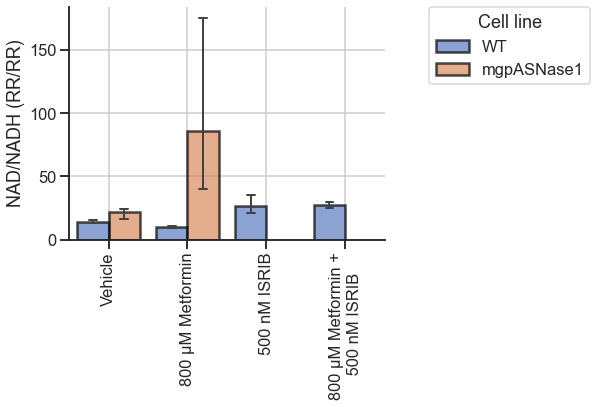

In [24]:
### NAD/NADH as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='NAD-NADH', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('NAD/NADH (RR/RR)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-NAD-NADH.pdf', bbox_inches='tight')

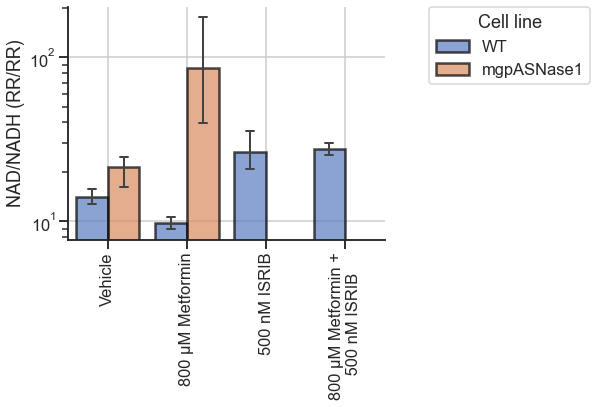

In [25]:
### NAD/NADH log as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='NAD-NADH', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('NAD/NADH (RR/RR)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-NAD-NADH_log.pdf', bbox_inches='tight')

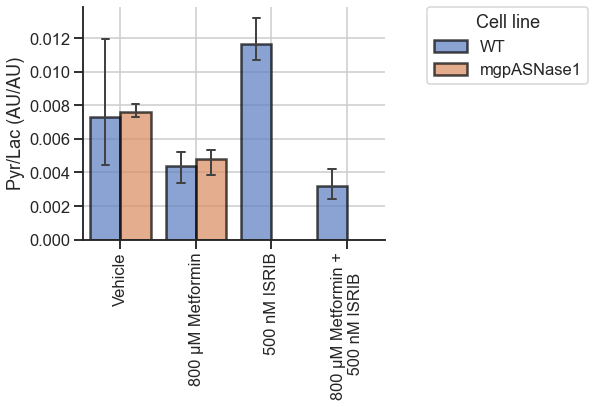

In [26]:
### Pyr/Lac as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Pyr-Lac', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Pyr/Lac (AU/AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Pyr-Lac.pdf', bbox_inches='tight')

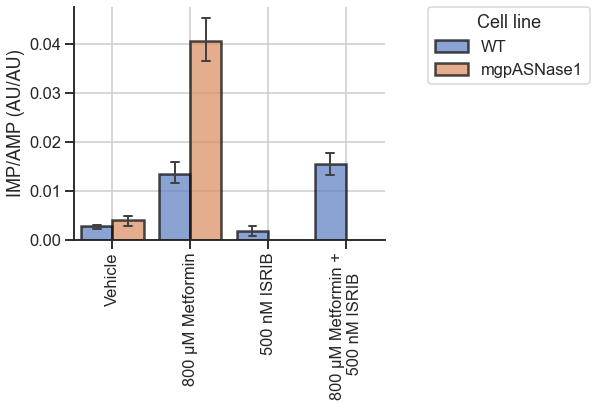

In [27]:
### IMP/AMP as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='IMP-AMP', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('IMP/AMP (AU/AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-IMP-AMP.pdf', bbox_inches='tight')

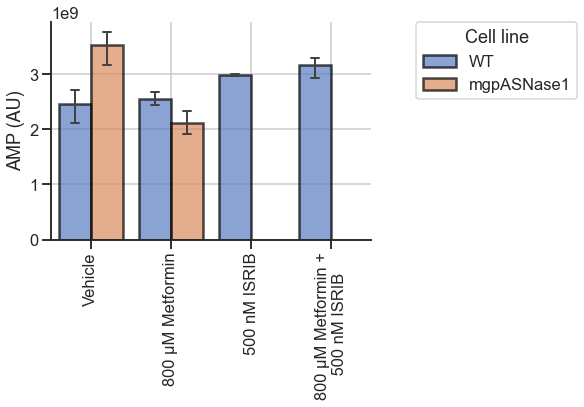

In [28]:
### AMP as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='AMP pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('AMP (AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-AMP.pdf', bbox_inches='tight')

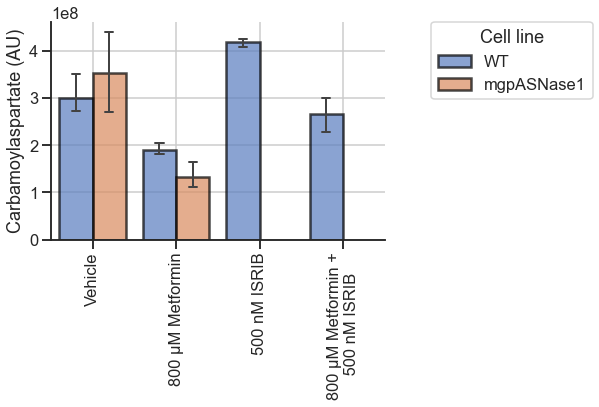

In [29]:
### Carbamoylaspartate as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Carbamoylaspartate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Carbamoylaspartate (AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Carbamoylaspartate.pdf', bbox_inches='tight')

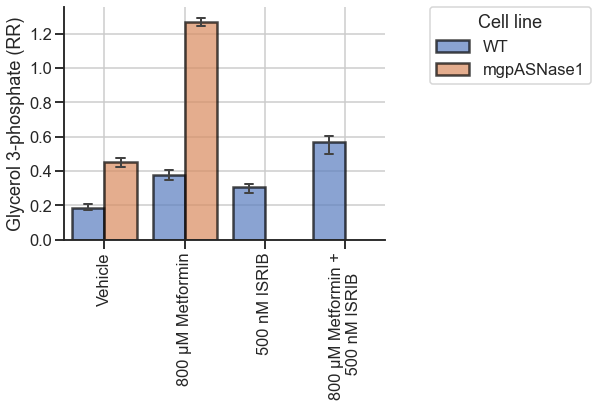

In [30]:
### Glycerol 3-phosphate as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Glycerol 3-phosphate neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Glycerol 3-phosphate (RR)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Glycerol-3-phosphate.pdf', bbox_inches='tight')

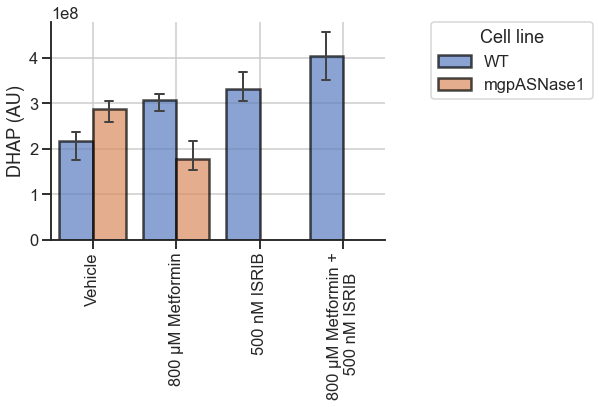

In [31]:
### DHAP as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='DHAP neg', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('DHAP (AU)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-DHAP.pdf', bbox_inches='tight')

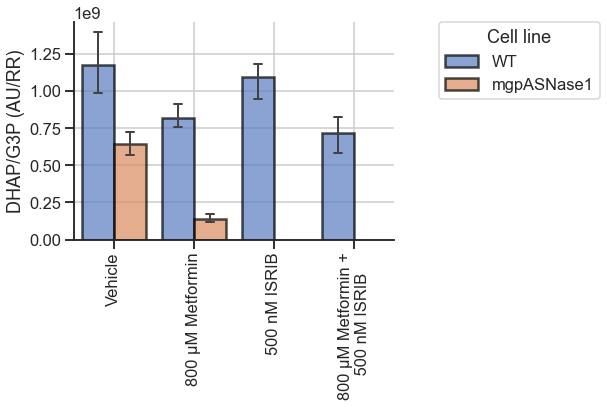

In [32]:
### DHAP/G3P as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='DHAP-G3P', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('DHAP/G3P (AU/RR)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-DHAP-G3P.pdf', bbox_inches='tight')

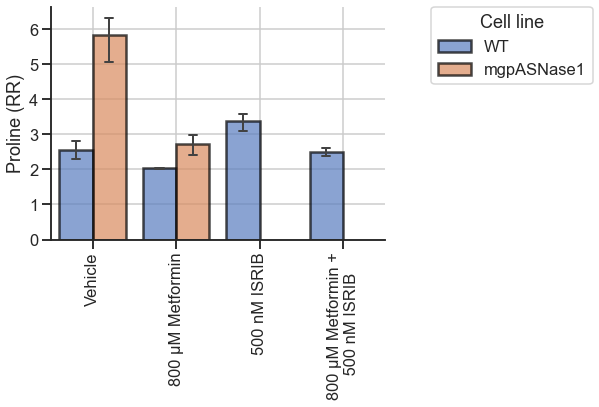

In [33]:
### Proline as a function of Treatment ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

mask = (df['Exp_time'] == 'Long')
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='Proline pos', hue='Cell_line', capsize=.1, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
#g1.set(yscale="log")

g1.set_xlabel('')
g1.set_ylabel('Proline (RR)')
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
# title = old_legend.get_title().get_text()
title = 'Cell line'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/long_treatment-Proline.pdf', bbox_inches='tight')

In [53]:
metab_names_mes

['3-Phosphoglycerate neg',
 'Adenosine pos',
 'Alanine pos',
 'alpha-Ketoglutarate neg',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'Carbamoylaspartate neg',
 'CMP neg',
 'Cytidine pos',
 'DHAP neg',
 'Fumarate neg',
 'Glucose 6-phosphate neg',
 'Glutamate neg',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'GMP pos',
 'Hypoxanthine pos',
 'IMP pos',
 'Lactate neg',
 'Malate neg',
 'Metformin pos',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phosphoenolpyruvate neg',
 'Proline pos',
 'Pyruvate neg',
 'SAICAR neg',
 'SAICAR pos',
 'Serine neg',
 'Succinate neg',
 'UMP neg',
 'Uridine neg',
 'Xanthine neg']